In [1]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import scipy.stats as stats
from matplotlib import gridspec
import aplpy as apl #The Astronomy Plotting Library for python
import astropy
from astropy.stats import sigma_clip
from astropy.modeling import functional_models, models, fitting
import astropy.units as U
from astropy.coordinates import ICRS, Galactic, FK4, FK5, Angle, Latitude, Longitude
import astropy.constants as C
from astropy import wcs
import astropy.io.fits as fits
from astropy.io import ascii
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.stats import signal_to_noise_oir_ccd as SNRas
#import spectral_cube as SC
#from spectral_cube import SpectralCube as sc
from astropy.wcs import WCS
matplotlib.use('Agg')
import matplotlib.cm as cm
#import astrometry as ast
import pyfits
import requests
import json
import os
from sklearn import datasets, linear_model
from scipy.optimize import curve_fit
import numpy.ma as ma
from astropy.table import Table, Column
import pyextract
import sewpy
import pandas as pd
from astropy import units as u
#import alipy

/home/lynge/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
quasJ = os.listdir('/../home/lynge/MasterP/NGC7213/NGC7213K/')
quasJ = [os.path.join('/../home/lynge/MasterP/NGC7213/NGC7213K',f) \
        for f in os.listdir('/../home/lynge/MasterP/NGC7213/NGC7213K/')]

qua1_RA_WORLD = SkyCoord('22:09:16.239  -47:09:59.95', unit=(u.hourangle, u.deg)).ra.degree
qua1_DEC_WORLD = SkyCoord('22:09:16.239  -47:09:59.95', unit=(u.hourangle, u.deg)).dec.degree

print qua1_RA_WORLD

sta1_RA_WORLD = SkyCoord('22:08:51.993  -47:10:28.64', unit=(u.hourangle, u.deg)).ra.degree #UCAC3 86-422902
sta1_DEC_WORLD = SkyCoord('22:08:51.993  -47:10:28.64', unit=(u.hourangle, u.deg)).dec.degree

sta2_RA_WORLD = SkyCoord('22:08:51.908  -47:07:20.88', unit=(u.hourangle, u.deg)).ra.degree #TYC 8438-1960-1
sta2_DEC_WORLD = SkyCoord('22:08:51.908  -47:07:20.88', unit=(u.hourangle, u.deg)).dec.degree

sta3_RA_WORLD = float('nan') #SkyCoord('05:58:11.342 -38:18:29.98', unit=(u.hourangle, u.deg)).ra.degree
sta3_DEC_WORLD = float('nan') #SkyCoord('05:58:11.342 -38:18:29.98', unit=(u.hourangle, u.deg)).dec.degree

sta4_RA_WORLD = float('nan') #SkyCoord('05:58:03.962 -38:19:15.51', unit=(u.hourangle, u.deg)).ra.degree
sta4_DEC_WORLD = float('nan') #SkyCoord('05:58:03.962 -38:19:15.51', unit=(u.hourangle, u.deg)).dec.degree

sky_RA_WORLD = SkyCoord('22:09:12 -47:12:44', unit=(u.hourangle, u.deg)).ra.degree #Random patch of sky
sky_DEC_WORLD = SkyCoord('22:09:12 -47:12:44', unit=(u.hourangle, u.deg)).dec.degree

print SkyCoord('22:09:12 -47:12:44', unit=(u.hourangle, u.deg)).dec.degree

MAG_STA1_J = 10.560
MAG_STA1_H = 10.026
MAG_STA1_K = 9.925

MAG_STA2_J = 11.588
MAG_STA2_H = 11.286
MAG_STA2_K = 11.175

MAG_STA3_J = float('nan') #12.068
MAG_STA3_H = float('nan') #11.855
MAG_STA3_K = float('nan') #11.796

MAG_STA4_J = float('nan') #13.188
MAG_STA4_H = float('nan') #12.771
MAG_STA4_K = float('nan') #12.737

MAG_VEGA_B = 0.03
MAG_VEGA_V = 0.03
MAG_VEGA_G = 0.03
MAG_VEGA_J = -0.18
MAG_VEGA_H = -0.03
MAG_VEGA_K = 0.13

FLUX_LAMBDA_VEGA_B = 632*10**(-11) #erg/cm**2/s/A
FLUX_LAMBDA_VEGA_V = 363.1*10**(-11)
FLUX_LAMBDA_VEGA_G = float('nan')
FLUX_LAMBDA_VEGA_J = 31.47*10**(-11)
FLUX_LAMBDA_VEGA_H = 11.38*10**(-11)
FLUX_LAMBDA_VEGA_K = 3.961*10**(-11)

FLUX_V_VEGA_B = 4.063*10**(-20) #erg/cm**2/s/Hz
FLUX_V_VEGA_V = 3.636*10**(-20)
FLUX_V_VEGA_G = float('nan')
FLUX_V_VEGA_J = 1.589*10**(-20)
FLUX_V_VEGA_H = 1.021*10**(-20)
FLUX_V_VEGA_K = 0.64*10**(-20)

332.3176625
-47.2122222222


In [3]:
def dist(mid,end):
    return np.sqrt((mid[0] - end[0])**2 + (mid[1] - end[1])**2)

In [4]:
def flux_cal(A_mag,B_mag,B_flux):
    '''Flux of A found through magnitude and flux of B'''
    return B_flux*10**((B_mag-A_mag)/2.5)

In [5]:
def Basic(quasar,header):
    '''Provides a basic list of neccesities from the fits header file for use in the later \
    flux determination, it does not serve an individual purpose beyound that'''
    AGNdata = quasar #np.rot90(np.rot90(np.fliplr(quasar)))
    #header = data[0].header
    #print header
    RAstd = header['CRVAL1']
    DECstd = header['CRVAL2']
    #print RAstd, DECstd
    pixspa = header['PIXSCALE']/(3600.)
    #print pixspa
    RAstdpix = header['CRPIX1']
    DECstdpix = header['CRPIX2']
    exptime = 10 # header['EXPTIME']
    return header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime

In [6]:
def curve(quasar,header,w,center,apparature):
    '''Determines the FLUX of the stellar object given the the numpy array of the image, \
    the header of the fits file, the astropy coordinate representation, \
    the object position and the apparature of interest'''
    header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime = Basic(quasar,header)
    #AGNdata = np.swapaxes(AGNdata,0,1)
    y, x = np.ogrid[0:header['NAXIS1'],0:header['NAXIS1']]
    #w = np.swapaxes(w,0,1)
    #F_AGN = np.zeros((512,512,3)) #((int(2*apparature/pixspa)+1,int(2*apparature/pixspa)+1,3))
    #print center
    x1 = w.all_world2pix(center[0],center[1],0)
    x1,y1 = (x1[0]),(x1[1])
    if 15 < x1 < header['NAXIS1'] - 15 and 15 < y1 < header['NAXIS2'] - 15:
        try:
            mask = ((y-y1)**2 + (x-x1)**2) > (apparature/float(pixspa))**2
            AGNdata[mask] = float(0)
            mask = AGNdata == 0.
            rows = np.flatnonzero((~mask).sum(axis=1))
            cols = np.flatnonzero((~mask).sum(axis=0))
            AGNdata = AGNdata[rows.min():rows.max()+1, cols.min():cols.max()+1]
            #print apparature/float(pixspa)
        except:
            AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    else:
        AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    #if np.sum(AGNdata) < 500:
    #    AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    return AGNdata, x1, y1


In [7]:
def comp1(qua,sta):
    '''Code to determine the relation between the AGN and the Stellar flux as determined by either me \
    or by the SExtractor program respectively'''
    comp = qua/sta
    return comp

In [8]:
def SXtable(quas,aperture):
    header = pyfits.getheader(quas)
    phot_app = aperture*3600/header['PIXSCALE']
    np.set_printoptions(threshold=np.inf)
    sew = sewpy.SEW(params=['XMODEL_WORLD', 'YMODEL_WORLD', 'X2MODEL_WORLD', 'Y2MODEL_WORLD', 
                            'XMODEL_IMAGE', 'YMODEL_IMAGE', 'FLUX_RADIUS(1)', 'FLUX_APER','ELLIPTICITY'],
                    config={"DETECT_THRESH":10, 'DETECT_MINAREA':5, 'DETECT_MAXAREA':10000, 
                            "PHOT_FLUXFRAC":"0.5", 'PHOT_APERTURES':2*phot_app, 
                            'PIXEL_SCALE':header['PIXSCALE']}
                    , sexpath='/usr/bin/sextractor')
    out = sew(quas)
    return out

In [9]:
def flux(quas,aperture,main_RA_WORLD,main_DEC_WORLD):
    header = pyfits.getheader(quas)
    RAmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[0]
    DECmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[1]
    output = float('nan')
    if 15 < RAmain < header['NAXIS1'] - 15 and 15 < DECmain < header['NAXIS2'] - 15: 
        out = SXtable(quas,aperture)
        RAmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,0)[0]
        DECmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,0)[1]
        #print out['table']['XMODEL_IMAGE'], out['table']['YMODEL_IMAGE']
        #print RAmain, DECmain
        
        for j in range(len(out['table']['XMODEL_IMAGE'])):
            #output['time'][i] = header['MJD-OBS']
            if RAmain - 5. < out['table']['XMODEL_IMAGE'][j] <  RAmain + 5. and \
            DECmain - 5. < out['table']['YMODEL_IMAGE'][j] < DECmain + 5.:
                #print 'YES'
                output = out['table']['FLUX_APER'][j]
                break
    else:
        output = float('nan')
        #print 'Done'
    return output


In [10]:
def SNR(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = data2
    
    return float(header['GAIN'])*data1_2*header['DIT']*header['NDIT']/(np.sqrt
                                                        (float(header['GAIN'])*data1_2*header['DIT']*header['NDIT'] 
                                                         + float(header['GAIN'])*npix1*data2_2*header['DIT']
                                                         *header['NDIT']
                                                         +header['NDIT']*npix1*header['RON']**2))
#SNRas(10.,data1_2,abs(data2_2),0,header['RON'],npix1,gain=header['GAIN'])

for i in range(len(quasJ)):
    data, header = fits.getdata(quasJ[i],header=True) #RA---TAN
    #print header['CTYPE2']
    header['CTYPE1'] = "RA---TAN"
    header['CTYPE2'] = "DEC--TAN"
    header['NDIT'] = 5
    '''header['A_ORDER'] = "0"
    header['B_ORDER'] = "0"
    header['AP_ORDER'] = "0"
    header['BP_ORDER'] = "0"
    header['A_0_2'] = "0"
    header['A_1_1'] = "0"
    header['A_2_0'] = "0"
    header['B_0_2'] = "0"
    header['B_1_1'] = "0"
    header['B_2_0'] = "0"
    header['AP_0_2'] = "0"
    header['AP_1_1'] = "0"
    header['AP_2_0'] = "0"
    header['AP_0_1'] = "0"
    header['AP_1_0'] = "0"
    header['BP_0_1'] = "0"
    header['BP_0_2'] = "0"
    header['BP_1_0'] = "0"
    header['BP_1_1'] = "0"
    header['BP_2_0'] = "0"'''
    fits.writeto(quasJ[i],data,header,clobber=True)
    #print fits.getheader(quasH[i])['A_ORDER']

In [11]:
def SEXAGNflux(quas,aperture1):
    aperture2 = aperture1 + 0.003
    date = []
    flucompsta1 = []
    flucompsta2 = []
    flucompsta3 = []
    flucompsta4 = []
    flucompsta5 = []
    flucompsta6 = []
    flucompsta7 = []
    poissonAGN = []
    poisson529 = []
    poisson22 = []
    poissonHD = []
    ABS_FLUX_LAMBDA_1 = 0
    ABS_FLUX_LAMBDA_2 = 0
    ABS_FLUX_LAMBDA_3 = 0
    ABS_FLUX_V_1 = 0
    ABS_FLUX_V_2 = 0
    ABS_FLUX_V_3 = 0
    SNR_comp = []
    comp_array = np.zeros((len(quas),7))
    SNR_array = np.zeros((len(quas),8))
    SNR_part = np.zeros((len(quas),4))
    gain = []
    #-----------------------------------------------------------------------------------------------
    for i in range(len(quas)):
        print 'Frame nr. ', i, quas[i]
        header = pyfits.getheader(quas[i])
        a_AGN = flux(quas[i],2*aperture1,qua1_RA_WORLD,qua1_DEC_WORLD)/header['DIT']
        a2 = flux(quas[i],2*aperture1,sta1_RA_WORLD,sta1_DEC_WORLD)/header['DIT']
        a3 = flux(quas[i],2*aperture1,sta2_RA_WORLD,sta2_DEC_WORLD)/header['DIT']
        a4 = flux(quas[i],2*aperture1,sta3_RA_WORLD,sta3_DEC_WORLD)/header['DIT']
        a5 = flux(quas[i],2*aperture1,sta4_RA_WORLD,sta4_DEC_WORLD)/header['DIT']
        a_sky = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sky_RA_WORLD,sky_DEC_WORLD),aperture1)[0]/header['DIT']
        #a_AGN_1 = flux(quas[i],2*aperture2,qua1_RA_WORLD,qua1_DEC_WORLD)/header['DIT']
        #a2_1 = flux(quas[i],2*aperture2,sta1_RA_WORLD,sta1_DEC_WORLD)/header['DIT']
        #a3_1 = flux(quas[i],2*aperture2,sta2_RA_WORLD,sta2_DEC_WORLD)/header['DIT']
        #a4_1 = flux(quas[i],2*aperture2,sta3_RA_WORLD,sta3_DEC_WORLD)/header['DIT']
        #-------------------------------------------------------------------------------------------
        #plt.figure(figsize=(3,3))
        #plt.imshow(a2)
        #plt.show()
        #-------------------------------------------------------------------------------------------
        a_AGN_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        #print a_AGN_pix
        a2_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a3_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a4_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a5_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a_sky_pix = np.count_nonzero(a_sky)
        a_sky_2 = np.sum(a_sky)/float(np.count_nonzero(a_sky))
        #a_AGN_pix_1 = np.pi*(2*aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a2_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a3_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a4_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a_AGN_2 = (np.sum(a_AGN_1) - np.sum(a_AGN))/(float(np.count_nonzero(a_AGN_1)) - float(np.count_nonzero(a_AGN)))
        #a2_2 = (np.sum(a2_1) - np.sum(a2))/(float(np.count_nonzero(a2_1)) - float(np.count_nonzero(a2)))
        #a3_2 = (np.sum(a3_1) - np.sum(a3))/(float(np.count_nonzero(a3_1)) - float(np.count_nonzero(a3)))
        #a4_2 = (np.sum(a4_1) - np.sum(a4))/(float(np.count_nonzero(a4_1)) - float(np.count_nonzero(a4)))
        a_AGN_3 = a_AGN/a_AGN_pix #- (a_AGN_1 - a_AGN)/(a_AGN_pix_1 - a_AGN_pix) #Background subtracted flux/pixel/sec
        a2_3 = a2/a2_pix #- (a2_1 - a2)/(a2_pix_1 - a2_pix)
        a3_3 = a3/a3_pix #- (a3_1 - a3)/(a3_pix_1 - a3_pix)
        a4_3 = a4/a4_pix #- (a4_1 - a4)/(a4_pix_1 - a4_pix)
        a5_3 = a5/a5_pix
        #-------------------------------------------------------------------------------------------
        date.append(header['MJD-OBS'])
        gain.append(header['gain'])
        #-------------------------------------------------------------------------------------------
        poissonAGN.append(np.sqrt(np.sum(a_AGN)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poissonHD.append(np.sqrt(np.sum(a2)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poisson22.append(np.sqrt(np.sum(a3)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poisson529.append(np.sqrt(np.sum(a4)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        #-------------------------------------------------------------------------------------------
        #if SNR1[i] < 70:
        #    flucompsta_AGN.append(float('nan'))
        #    flucompsta2.append(float('nan'))
        #    flucompsta3.append(float('nan'))
        #    flucompsta4.append(float('nan'))
        #    flucompsta6.append(float('nan'))
        #    comp_array[i,0] = int(date[i])
        #    comp_array[i,1] = float('nan')
        #    comp_array[i,2] = float('nan')
        #    comp_array[i,3] = float('nan')
        #else:
        flucompsta1.append(comp1(a_AGN_3,a2_3))
        flucompsta2.append(comp1(a_AGN_3,a3_3))
        flucompsta3.append(comp1(a_AGN_3,a4_3))
        flucompsta4.append(comp1(a_AGN_3,a5_3))
        flucompsta5.append(comp1(a2_3,a3_3))
        #flucompsta5.append(comp1(a_AGN_3,a6_3))
        #flucompsta6.append(comp1(a_AGN_3,a7_3))
        comp_array[i,0] = int(date[i])
        comp_array[i,1] = flucompsta1[i]
        comp_array[i,2] = flucompsta2[i]
        comp_array[i,3] = flucompsta3[i]
        #comp_array[i,4] = flucompsta4[i]
        #comp_array[i,5] = flucompsta5[i]
        #comp_array[i,6] = flucompsta6[i]
        print a_AGN
        #SNR_array[i,0] = int(date[i])
        #SNR_array[i,1] = SNR(a_AGN,a_sky,header,aperture1,aperture1)
        #SNR_array[i,2] = SNR(a2,a_sky,header,aperture1,aperture1)
        #SNR_array[i,3] = SNR(a3,a_sky,header,aperture1,aperture1)
        #SNR_array[i,4] = SNR(a4,a_sky,header,aperture1,aperture1)
        #SNR_array[i,5] = SNR(a5,a_sky,header,aperture1,aperture1)
        #SNR_array[i,6] = SNR(a6,a_sky,header,aperture1,aperture1)
        #SNR_array[i,7] = SNR(a7,a_sky,header,aperture1,aperture1)
        SNR_part[i,0] = date[i]
        SNR_part[i,1] = gain[i]*header['NDIT']*a_AGN_3*header['DIT']*a_AGN_pix
        SNR_part[i,2] = gain[i]*header['NDIT']*np.sum(a_sky)*header['DIT']
        SNR_part[i,3] = header['NDIT']*a_AGN_pix*header['RON']**2
    #print 'YES'
    #-----------------------------------------------------------------------------------------------
    poissonAGN = np.array(poissonAGN)
    poissonHD = np.array(poissonHD)
    poisson22 = np.array(poisson22)
    poisson529 = np.array(poisson529)
    comp_array = comp_array[comp_array[:,0].argsort()]
    #-----------------------------------------------------------------------------------------------
    ABS_FLUX_LAMBDA_1 = np.array(flucompsta1)*flux_cal(MAG_STA1_K,MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_LAMBDA_2 = np.array(flucompsta2)*flux_cal(MAG_STA2_K,MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_LAMBDA_3 = np.array(flucompsta3)*flux_cal(MAG_STA3_K,MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_LAMBDA_4 = np.array(flucompsta4)*flux_cal(MAG_STA4_K,MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_V_1 = np.array(flucompsta1)*flux_cal(MAG_STA1_K,MAG_VEGA_K,FLUX_V_VEGA_K)
    ABS_FLUX_V_2 = np.array(flucompsta2)*flux_cal(MAG_STA2_K,MAG_VEGA_K,FLUX_V_VEGA_K)
    ABS_FLUX_V_3 = np.array(flucompsta3)*flux_cal(MAG_STA3_K,MAG_VEGA_K,FLUX_V_VEGA_K)
    ABS_FLUX_V_4 = np.array(flucompsta4)*flux_cal(MAG_STA4_K,MAG_VEGA_K,FLUX_V_VEGA_K)
    #-----------------------------------------------------------------------------------------------
    return comp_array,SNR_array,ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,ABS_FLUX_LAMBDA_4,\
ABS_FLUX_V_1,ABS_FLUX_V_2,ABS_FLUX_V_3,ABS_FLUX_V_4,date,SNR_part,flucompsta5

In [12]:
def AGNflux(quas,aperture1):
    aperture2 = aperture1 + 0.001
    date = []
    flucompsta1 = []
    flucompsta2 = []
    flucompsta3 = []
    flucompsta4 = []
    flucompsta5 = []
    flucompsta6 = []
    flucompsta7 = []
    SNR1 = []
    SNR2 = []
    SNR3 = []
    SNR4 = []
    SNR5 = []
    poissonAGN = []
    poisson529 = []
    poisson22 = []
    poissonHD = []
    ABS_FLUX_LAMBDA_1 = 0
    ABS_FLUX_LAMBDA_2 = 0
    ABS_FLUX_LAMBDA_3 = 0
    ABS_FLUX_LAMBDA_4 = 0
    ABS_FLUX_V_1 = 0
    ABS_FLUX_V_2 = 0
    ABS_FLUX_V_3 = 0
    ABS_FLUX_V_4 = 0
    SNR_comp = []
    SNR_test = np.zeros((len(quas),3))
    SNR_part = np.zeros((len(quas),5))
    file1 = []
    gain = []
    for i in range(len(quas)):
        #print 'Frame nr. ', i
        header = pyfits.getheader(quas[i])
        a1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (qua1_RA_WORLD,qua1_DEC_WORLD),aperture1)[0]/header['DIT'] #float(header['EXPTIME'])
        a2 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta1_RA_WORLD,sta1_DEC_WORLD),aperture1)[0]/header['DIT'] #float(header['EXPTIME'])
        a3 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta2_RA_WORLD,sta2_DEC_WORLD),aperture1)[0]/header['DIT'] #float(header['EXPTIME'])
        a4 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta3_RA_WORLD,sta3_DEC_WORLD),aperture1)[0]/header['DIT'] #float(header['EXPTIME'])
        a5 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta4_RA_WORLD,sta4_DEC_WORLD),aperture1)[0]/header['DIT']
        a_sky = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sky_RA_WORLD,sky_DEC_WORLD),aperture1)[0]/header['DIT'] #float(header['EXPTIME'])
        a1_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (qua1_RA_WORLD,qua1_DEC_WORLD),aperture2)[0]/header['DIT'] #float(header['EXPTIME'])
        a2_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta1_RA_WORLD,sta1_DEC_WORLD),aperture2)[0]/header['DIT'] #float(header['EXPTIME'])
        a3_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta2_RA_WORLD,sta2_DEC_WORLD),aperture2)[0]/header['DIT'] #float(header['EXPTIME'])
        a4_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta3_RA_WORLD,sta3_DEC_WORLD),aperture2)[0]/header['DIT'] #float(header['EXPTIME'])
        a5_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta4_RA_WORLD,sta4_DEC_WORLD),aperture2)[0]/header['DIT']
        date.append(header['MJD-OBS'])
        gain.append(header['gain'])
        a_AGN_pix = np.count_nonzero(a1) #np.pi*(2*aperture1)**2/
        #plt.figure()
        #plt.imshow(a1)
        #plt.show()
        a2_pix = np.count_nonzero(a2)
        a3_pix = np.count_nonzero(a3)
        a4_pix = np.count_nonzero(a4)
        a5_pix = np.count_nonzero(a5)
        a_AGN_pix_1 = np.count_nonzero(a1_1)
        a2_pix_1 = np.count_nonzero(a2_1)
        a3_pix_1 = np.count_nonzero(a3_1)
        a4_pix_1 = np.count_nonzero(a4_1)
        a5_pix_1 = np.count_nonzero(a5_1)
        a_AGN_3 = np.sum(a1)/a_AGN_pix - (np.sum(a1_1) - np.sum(a1))/(a_AGN_pix_1 - a_AGN_pix)#Background subtracted flux/pixel/sec
        a2_3 = np.sum(a2)/a2_pix - (np.sum(a2_1) - np.sum(a2))/(a2_pix_1 - a2_pix)
        a3_3 = np.sum(a3)/a3_pix - (np.sum(a3_1) - np.sum(a3))/(a3_pix_1 - a3_pix)
        a4_3 = np.sum(a4)/a4_pix - (np.sum(a4_1) - np.sum(a4))/(a4_pix_1 - a4_pix)
        a5_3 = np.sum(a5)/a5_pix - (np.sum(a5_1) - np.sum(a5))/(a5_pix_1 - a5_pix)
        flucompsta1.append(comp1(a_AGN_3,a2_3))
        flucompsta2.append(comp1(a_AGN_3,a3_3))
        flucompsta3.append(comp1(a_AGN_3,a4_3))
        flucompsta4.append(comp1(a_AGN_3,a5_3))
        flucompsta5.append(comp1(a2_3,a3_3))
        SNR1.append(SNR(np.sum(a1),np.sum(a_sky),header,aperture1,aperture1))
        SNR2.append(SNR(np.sum(a2),np.sum(a_sky),header,aperture1,aperture1))
        SNR3.append(SNR(np.sum(a3),np.sum(a_sky),header,aperture1,aperture1))
        SNR4.append(SNR(np.sum(a4),np.sum(a_sky),header,aperture1,aperture1))
        poissonAGN.append(np.sqrt(np.sum(a1)*header['DIT']))
        poissonHD.append(np.sqrt(np.sum(a2)*header['DIT']))
        poisson22.append(np.sqrt(np.sum(a3)*header['DIT']))
        poisson529.append(np.sqrt(np.sum(a4)*header['DIT']))
        SNR_test[i,0] = date[i]
        SNR_test[i,1] = SNR1[i]
        SNR_test[i,2] = gain[i]
        SNR_part[i,0] = date[i]
        SNR_part[i,1] = gain[i]*header['NDIT']*a_AGN_3*header['DIT']*a_AGN_pix
        SNR_part[i,2] = gain[i]*header['NDIT']*np.sum(a_sky)*header['DIT']
        SNR_part[i,3] = header['NDIT']*a_AGN_pix*header['RON']**2
        SNR_part[i,4] = header['AIRMASS']
        file1.append(quas[i])
        #print header['EXPTIME']
    poissonAGN = np.array(poissonAGN)
    poissonHD = np.array(poissonHD)
    poisson22 = np.array(poisson22)
    poisson529 = np.array(poisson529)
    #SNR_test = np.array((date,SNR1,gain))
    ABS_FLUX_LAMBDA_1 = np.array(flucompsta1)*flux_cal(MAG_STA1_K,MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_LAMBDA_2 = np.array(flucompsta2)*flux_cal(MAG_STA2_K,MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_LAMBDA_3 = np.array(flucompsta3)*flux_cal(MAG_STA3_K,MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_LAMBDA_4 = np.array(flucompsta4)*flux_cal(MAG_STA4_K,MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_V_1 = np.array(flucompsta1)*flux_cal(MAG_STA1_K,MAG_VEGA_K,FLUX_V_VEGA_K)
    ABS_FLUX_V_2 = np.array(flucompsta2)*flux_cal(MAG_STA2_K,MAG_VEGA_K,FLUX_V_VEGA_K)
    ABS_FLUX_V_3 = np.array(flucompsta3)*flux_cal(MAG_STA3_K,MAG_VEGA_K,FLUX_V_VEGA_K)
    ABS_FLUX_V_4 = np.array(flucompsta4)*flux_cal(MAG_STA4_K,MAG_VEGA_K,FLUX_V_VEGA_K) 
    return np.array(flucompsta1),np.array(flucompsta2),np.array(flucompsta3),np.array(flucompsta4),\
np.array(flucompsta5),np.array(flucompsta6),np.array(flucompsta7),np.array(SNR1),np.array(SNR2),np.array(SNR3),\
np.array(SNR4),np.array(SNR5),np.array(SNR_comp),ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,\
ABS_FLUX_LAMBDA_4,ABS_FLUX_V_1,ABS_FLUX_V_2,ABS_FLUX_V_3,ABS_FLUX_V_4,date,\
poissonAGN,poissonHD,poisson22,poisson529,SNR_test,file1,SNR_part

In [13]:
comp_array,SNR_array,ABS_FLUX_LAMBDA_1_1,ABS_FLUX_LAMBDA_2_1,ABS_FLUX_LAMBDA_3_1,ABS_FLUX_LAMBDA_4_1,\
ABS_FLUX_V_1_1,ABS_FLUX_V_2_1,ABS_FLUX_V_3_1,ABS_FLUX_V_4_1,date_1,SNR_part_1,flucompsta5_1 = SEXAGNflux(quasJ,0.0005)

Frame nr.  0 /../home/lynge/MasterP/NGC7213/NGC7213K/17-NGC7213K.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
No handlers could be found for logger "sewpy.sewpy"


nan
Frame nr.  1 /../home/lynge/MasterP/NGC7213/NGC7213K/47-NGC7213K.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


5203.568
Frame nr.  2 /../home/lynge/MasterP/NGC7213/NGC7213K/18-NGC7213K.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


4620.902
Frame nr.  3 /../home/lynge/MasterP/NGC7213/NGC7213K/9-NGC7213K.fits
nan
Frame nr.  4 /../home/lynge/MasterP/NGC7213/NGC7213K/16-NGC7213K.fits
4497.3
Frame nr.  5 /../home/lynge/MasterP/NGC7213/NGC7213K/48-NGC7213K.fits
4750.475
Frame nr.  6 /../home/lynge/MasterP/NGC7213/NGC7213K/33-NGC7213K.fits
nan
Frame nr.  7 /../home/lynge/MasterP/NGC7213/NGC7213K/50-NGC7213K.fits
5010.835
Frame nr.  8 /../home/lynge/MasterP/NGC7213/NGC7213K/32-NGC7213K.fits
nan
Frame nr.  9 /../home/lynge/MasterP/NGC7213/NGC7213K/13-NGC7213K.fits
5090.063
Frame nr.  10 /../home/lynge/MasterP/NGC7213/NGC7213K/53-NGC7213K.fits
nan
Frame nr.  11 /../home/lynge/MasterP/NGC7213/NGC7213K/59-NGC7213K.fits
4534.855
Frame nr.  12 /../home/lynge/MasterP/NGC7213/NGC7213K/54-NGC7213K.fits
4808.42
Frame nr.  13 /../home/lynge/MasterP/NGC7213/NGC7213K/44-NGC7213K.fits
nan
Frame nr.  14 /../home/lynge/MasterP/NGC7213/NGC7213K/51-NGC7213K.fits
5319.297
Frame nr.  15 /../home/lynge/MasterP/NGC7213/NGC7213K/27-NGC7213K.f

In [14]:
COMB = np.ndarray.tolist(ABS_FLUX_LAMBDA_1_1) + np.ndarray.tolist(ABS_FLUX_LAMBDA_2_1) + np.ndarray.tolist(ABS_FLUX_LAMBDA_3_1)
datelist = date_1 + date_1 + date_1

COMB_array = np.array((datelist,COMB))
print COMB_array[0,:]
np.savetxt('K-NGC7213',COMB_array)

[ 57962.26511333  57613.223874    57958.260238    58003.15159333
  57973.288202    57609.43523     57736.1415425   57600.419708
  57742.1504775   57986.374676    57584.30529     57554.267528
  57581.301206    57623.189598    57593.424776    57906.378444
  57916.362364    57700.167296    57728.136034    57694.274822
  58010.121954    57913.3583125   58017.082874    57550.398306
  58047.24067667  57925.26473     58050.244922    57576.363674    57587.35934
  57566.408662    58065.234382    58021.054024    57933.283805
  57529.410876    57534.29553     57707.251716    57561.334854
  57714.231164    57733.137496    57954.351744    57626.19384     57632.314254
  57616.241548    57557.377266    57903.374242    57619.397786
  58053.280335    57980.099766    57993.177494    57749.107506
  57876.370276    58062.228214    57629.293415    57983.370446
  57703.224464    57948.319474    57990.173272    57951.323704
  58000.147242    57690.0384      57936.2884275   57746.036178
  57606.430988    5796

In [15]:
flucompsta1,flucompsta2,flucompsta3,flucompsta4,flucompsta5,flucompsta6,flucompsta7,\
SNR1,SNR2,SNR3,SNR4,SNR5,SNR_comp,ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,ABS_FLUX_LAMBDA_4,ABS_FLUX_V_1,\
ABS_FLUX_V_2,ABS_FLUX_V_3,ABS_FLUX_V_4,date,poissonAGN,poissonHD,poisson22,poisson529,SNR_test,file1,SNR_part \
= AGNflux(quasJ,0.002)

/home/lynge/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/home/lynge/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in sqrt
/home/lynge/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in sqrt
/home/lynge/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in sqrt


[             nan   7.99772449e-15   7.64869998e-15              nan
   8.26445652e-15   7.97231449e-15              nan   8.10269651e-15
              nan   8.60590724e-15              nan   7.74820433e-15
              nan              nan   8.30465713e-15              nan
   7.80550201e-15   8.20430876e-15              nan              nan
              nan              nan              nan   7.99804339e-15
              nan   8.20659155e-15              nan   7.95949218e-15
              nan   8.16561487e-15              nan              nan
              nan   8.30356577e-15   7.90924772e-15              nan
              nan              nan              nan              nan
   8.11874326e-15              nan              nan              nan
              nan              nan              nan   7.49122230e-15
              nan              nan   8.13905177e-15              nan
   7.73294228e-15   7.92407745e-15              nan   8.50463767e-15
   7.86165057e-15   7.57526574e-15

/home/lynge/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


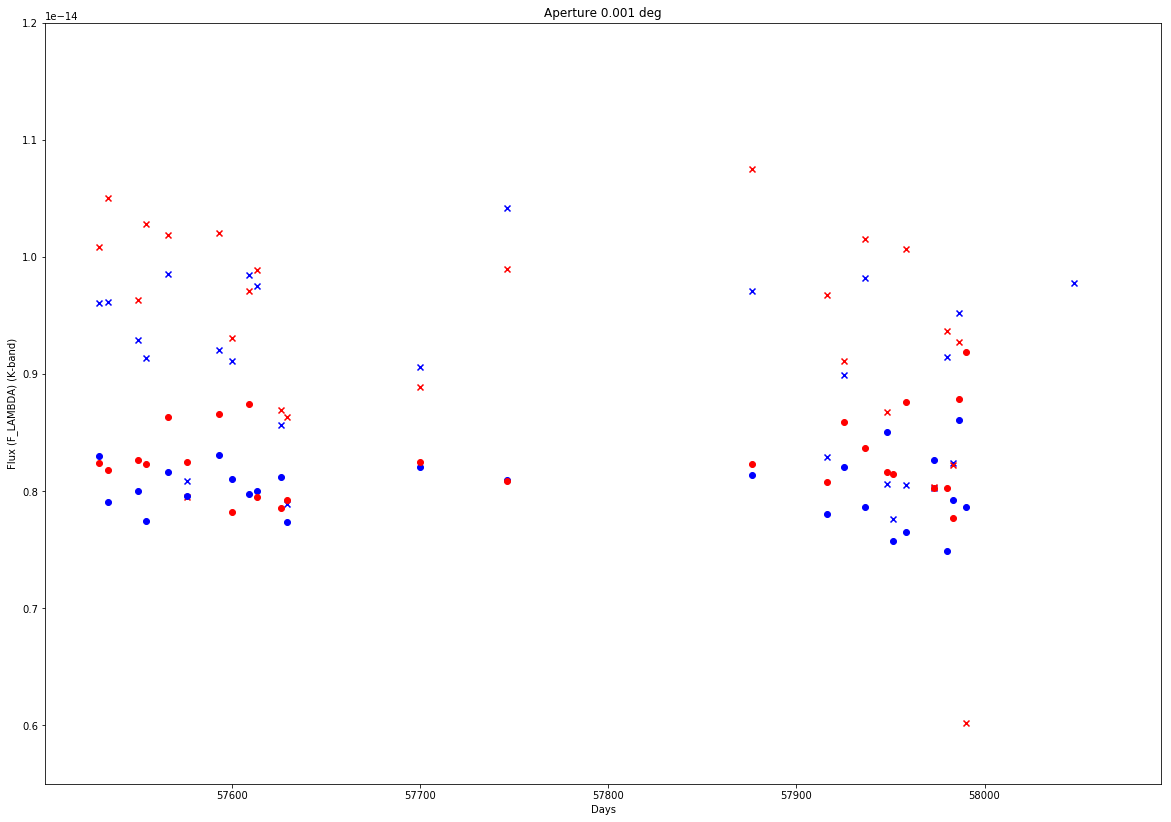

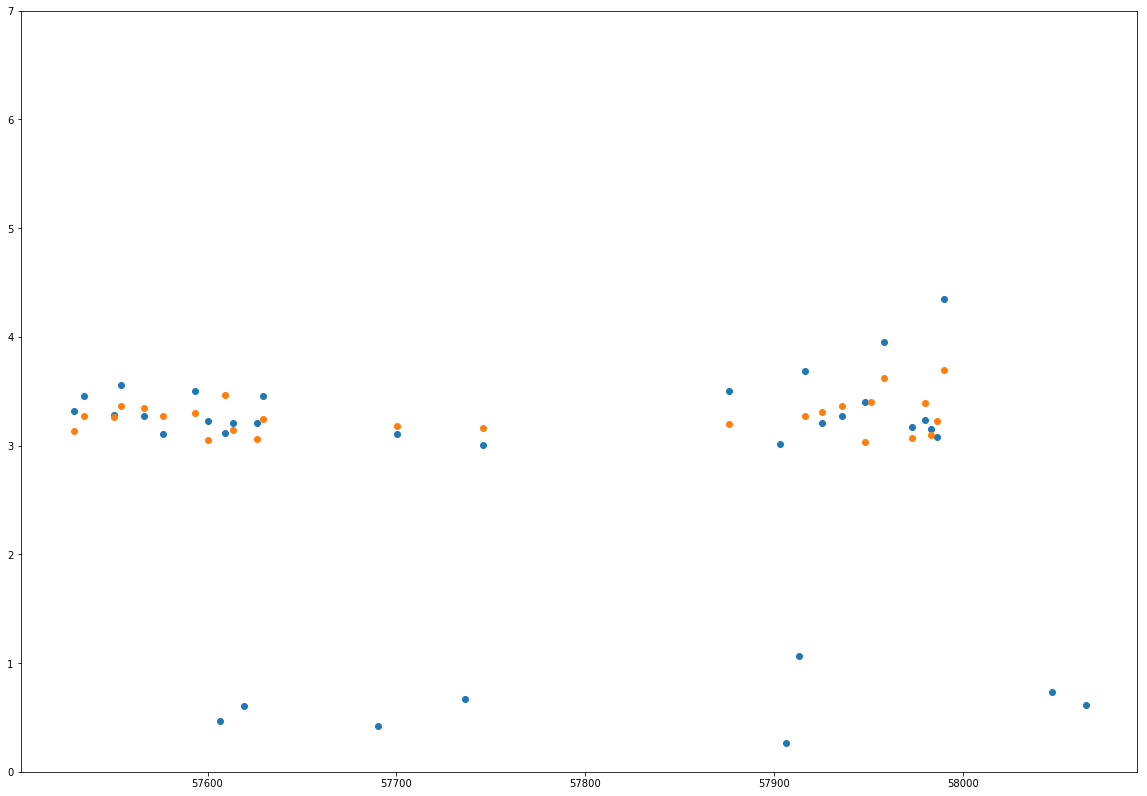

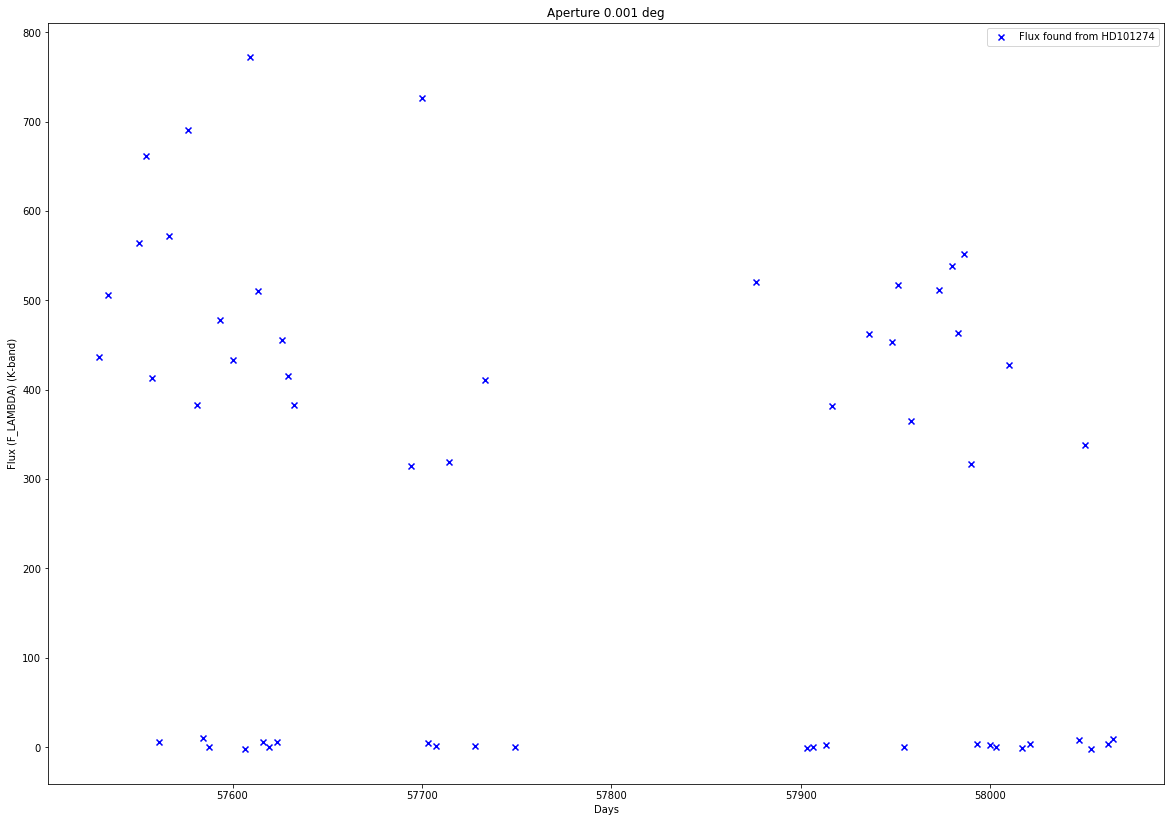

In [16]:
print ABS_FLUX_LAMBDA_1_1
plt.figure(figsize=(20,14))
plt.scatter(date,np.array(ABS_FLUX_LAMBDA_1),marker='x',color='b')
plt.scatter(date,np.array(ABS_FLUX_LAMBDA_2),marker='x',color='r')
plt.scatter(date,np.array(ABS_FLUX_LAMBDA_3),marker='x',color='g')
plt.scatter(date,np.array(ABS_FLUX_LAMBDA_4),marker='x',color='purple')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_1_1),marker='o',color='b')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_2_1),marker='o',color='r')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3_1),marker='o',color='g')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_4_1),marker='o',color='purple')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
plt.ylim([0.55*10**(-14),1.2*10**(-14)])
plt.legend()
plt.show()

plt.figure(figsize=(20,14))
plt.scatter(date,flucompsta5)
plt.scatter(date_1,flucompsta5_1)
#plt.yscale('log')
plt.ylim([0,7])
plt.legend()
plt.show()


plt.figure(figsize=(20,14))
plt.scatter(date,np.array(SNR1),marker='x',\
            color='b',label='Flux found from HD101274')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
#plt.ylim([0.15,0.20])
#plt.xlim([57850,57880])
plt.legend()
plt.show()



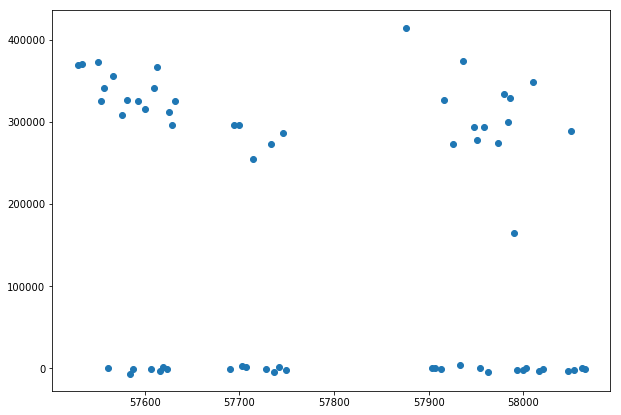

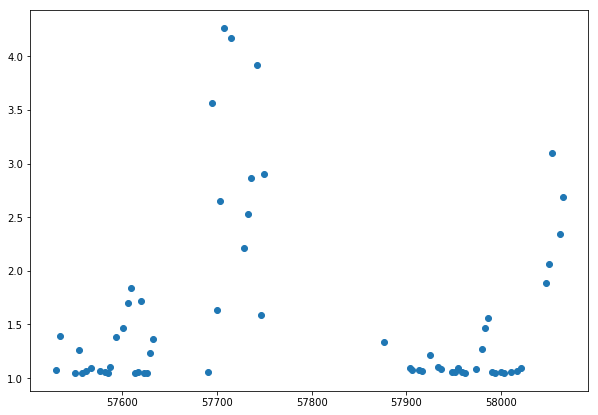

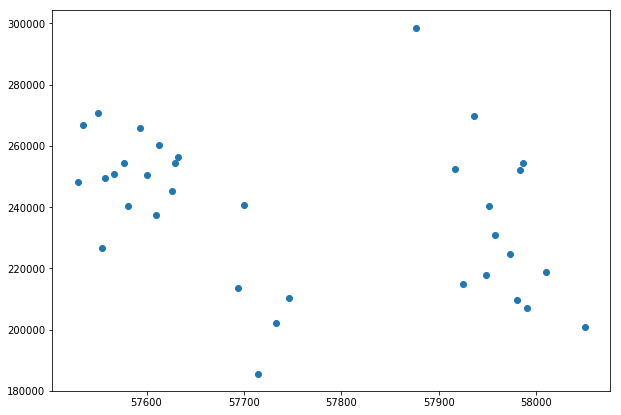

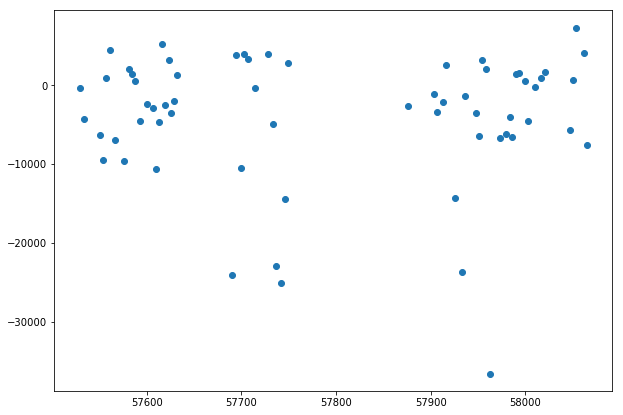

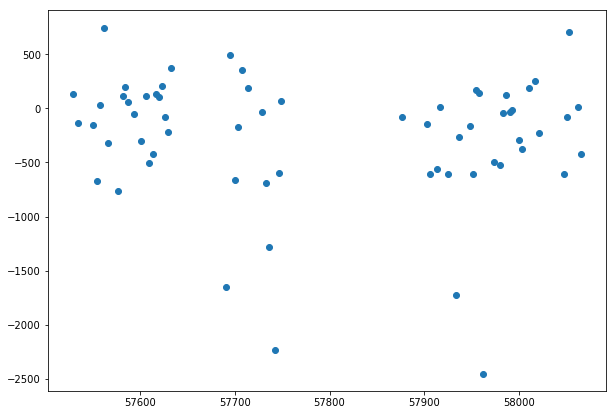

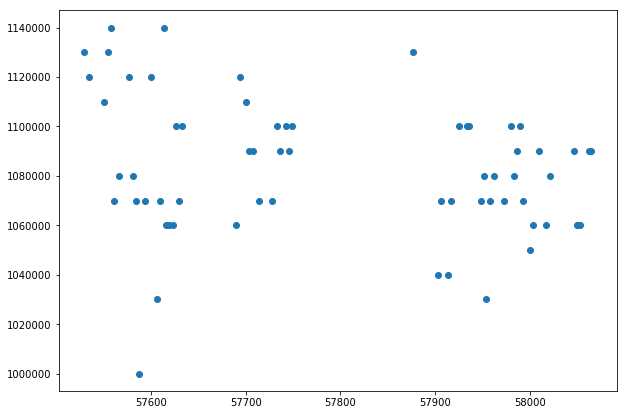

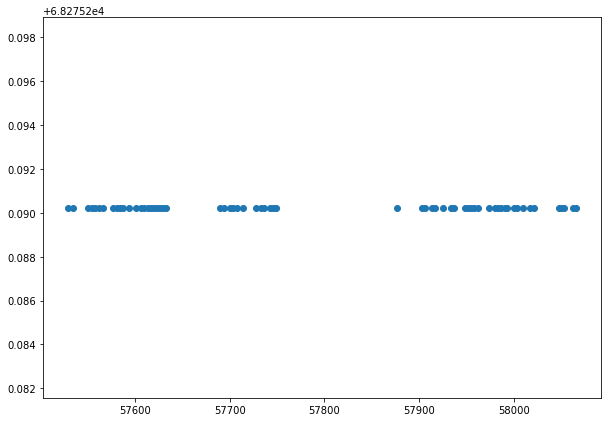

In [17]:
plt.figure(figsize=(10,7))
plt.scatter(SNR_part[:,0],SNR_part[:,1])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part[:,0],SNR_part[:,4])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,1])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part[:,0],SNR_part[:,2])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,2])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part[:,0],SNR_part[:,3])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,3])
plt.show()


In [18]:
print np.argmax(SNR_test[:,1])

for i in range(len(file1)):
    print i, '{0:f}'.format(SNR_test[i,0]), '{0:f}'.format(SNR_test[i,1]), '{0:f}'.format(SNR_test[i,2])
    print file1[i]

0
0 57962.265113 nan 5.000000
/../home/lynge/MasterP/NGC7213/NGC7213K/17-NGC7213K.fits
1 57613.223874 510.677091 5.000000
/../home/lynge/MasterP/NGC7213/NGC7213K/47-NGC7213K.fits
2 57958.260238 364.670936 5.000000
/../home/lynge/MasterP/NGC7213/NGC7213K/18-NGC7213K.fits
3 58003.151593 0.342583 5.000000
/../home/lynge/MasterP/NGC7213/NGC7213K/9-NGC7213K.fits
4 57973.288202 511.971302 5.000000
/../home/lynge/MasterP/NGC7213/NGC7213K/16-NGC7213K.fits
5 57609.435230 771.826063 5.000000
/../home/lynge/MasterP/NGC7213/NGC7213K/48-NGC7213K.fits
6 57736.141543 nan 5.000000
/../home/lynge/MasterP/NGC7213/NGC7213K/33-NGC7213K.fits
7 57600.419708 433.296592 5.000000
/../home/lynge/MasterP/NGC7213/NGC7213K/50-NGC7213K.fits
8 57742.150477 nan 5.000000
/../home/lynge/MasterP/NGC7213/NGC7213K/32-NGC7213K.fits
9 57986.374676 551.832824 5.000000
/../home/lynge/MasterP/NGC7213/NGC7213K/13-NGC7213K.fits
10 57584.305290 10.603778 5.000000
/../home/lynge/MasterP/NGC7213/NGC7213K/53-NGC7213K.fits
11 57554.2